In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

In [4]:
# 辅助函数：计算成交量状态（量峰、量岭、量谷）
def calculate_volume_state(df, window_days=20):
    """
    计算每根K线的成交量状态：
    0 = 量谷 (温和成交量)
    1 = 量峰 (孤立喷发成交量)
    2 = 量岭 (连续喷发成交量)
    """
    # 创建时间点标识 (HH:MM)
    df = df.copy()
    df['time_point'] = df.index.strftime('%H:%M')
    
    # 计算过去20天同时点的成交量统计
    history = df.groupby('time_point')['volume'].rolling(window_days, min_periods=10).agg(['mean', 'std']).shift(1)
    history.columns = ['hist_mean', 'hist_std']
    df = df.join(history, on=['time_point', df.index])
    
    # 计算喷发阈值
    df['eruption_threshold'] = df['hist_mean'] + df['hist_std']
    
    # 标记喷发成交量
    df['is_eruption'] = df['volume'] > df['eruption_threshold']
    
    # 标记连续喷发 (前后相邻K线也是喷发)
    df['prev_eruption'] = df['is_eruption'].shift(1).fillna(False)
    df['next_eruption'] = df['is_eruption'].shift(-1).fillna(False)
    
    # 定义状态: 
    # 量峰 = 当前喷发但前后都不喷发 (孤立喷发)
    # 量岭 = 当前喷发且前后至少有一个喷发 (连续喷发)
    # 量谷 = 非喷发
    conditions = [
        df['is_eruption'] & ~df['prev_eruption'] & ~df['next_eruption'],  # 量峰
        df['is_eruption'] & (df['prev_eruption'] | df['next_eruption']),  # 量岭
        ~df['is_eruption']  # 量谷
    ]
    choices = [1, 2, 0]
    df['volume_state'] = np.select(conditions, choices, default=0)
    
    return df['volume_state']

# 因子1: 量峰分钟数因子

In [5]:
def calculate_peak_count(df):
    """
    量峰分钟数因子：滚动窗口内量峰出现的次数
    """
    volume_state = calculate_volume_state(df)
    # 过去1天窗口(96根K线)的量峰计数
    return volume_state.eq(1).rolling(96).sum()

因子测试框架 - 量峰分钟数因子


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.004840
   Rank_IC (Spearman): 0.006345
📊 信息比率:
   IR: nan
   有效分组数: 8
📊 因子分布:
📋 数据概况:
   数据长度: 132111
   因子列: volume_peak_count
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


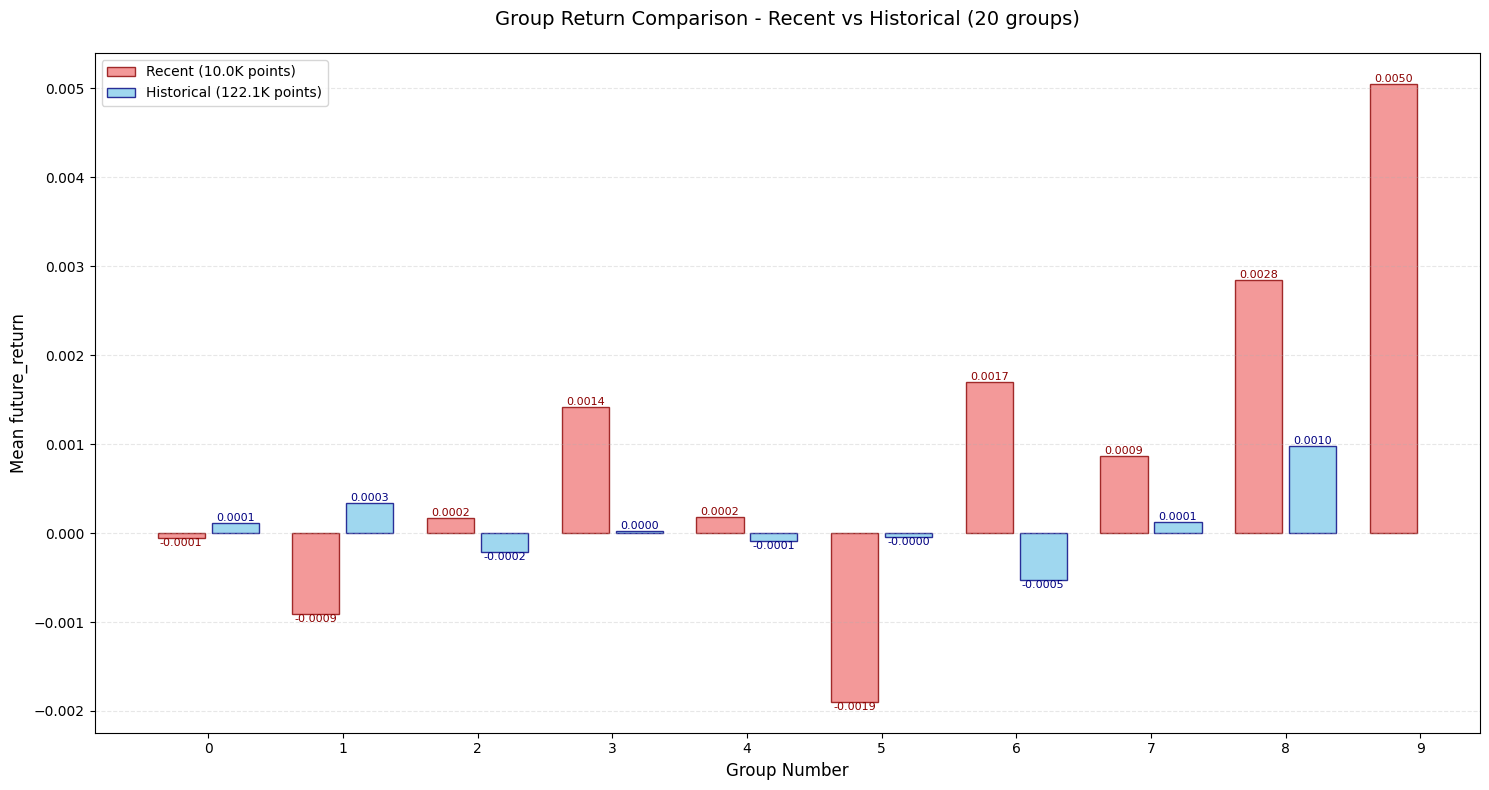

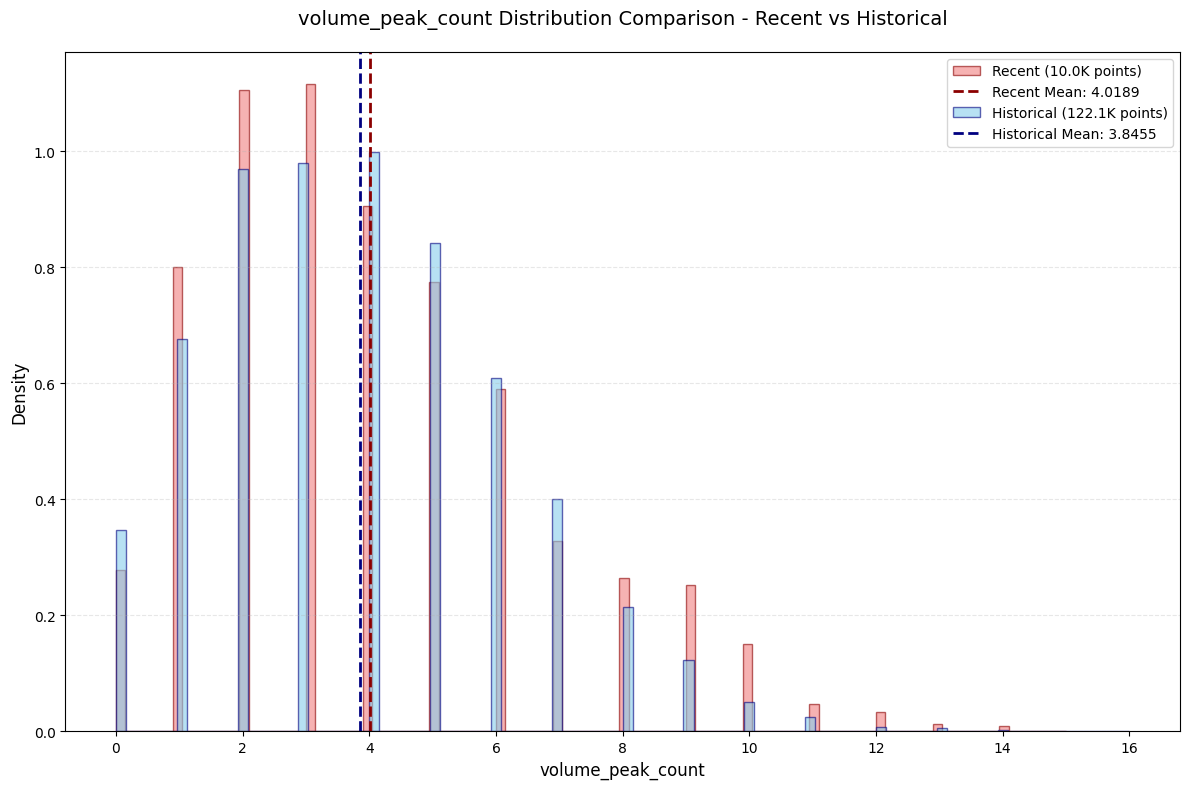

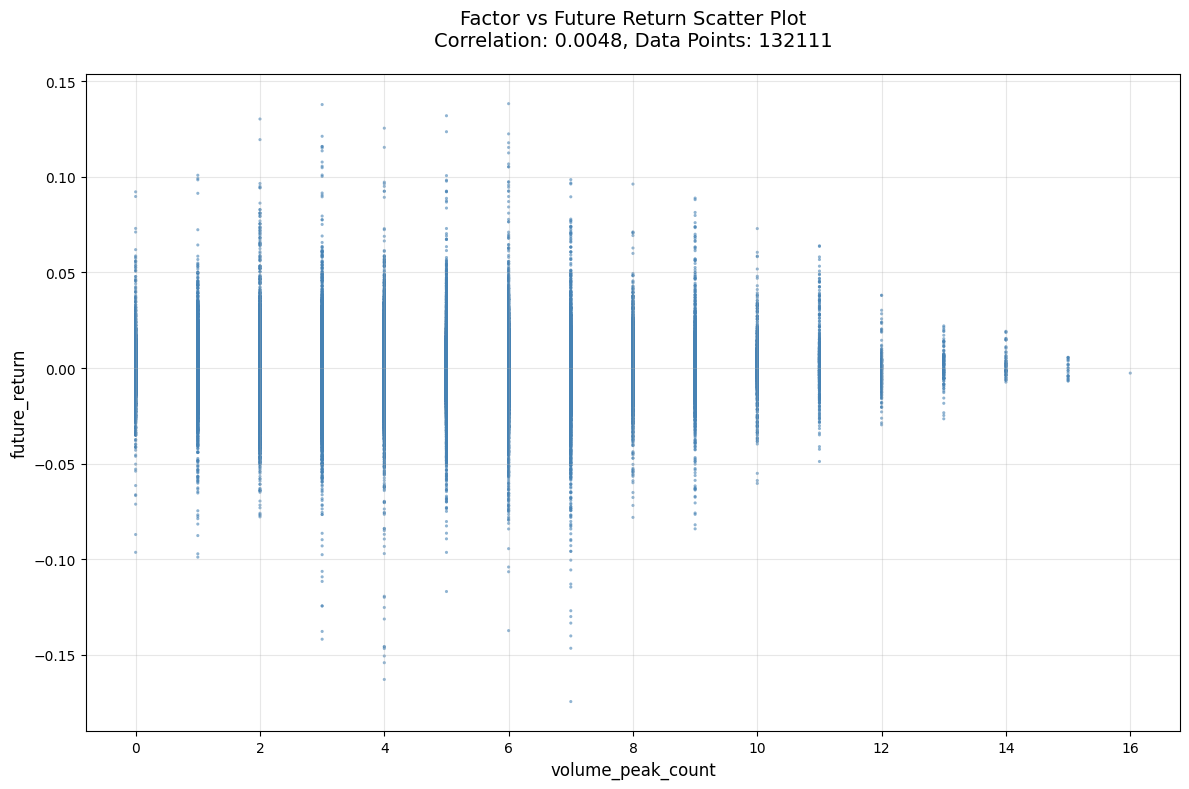

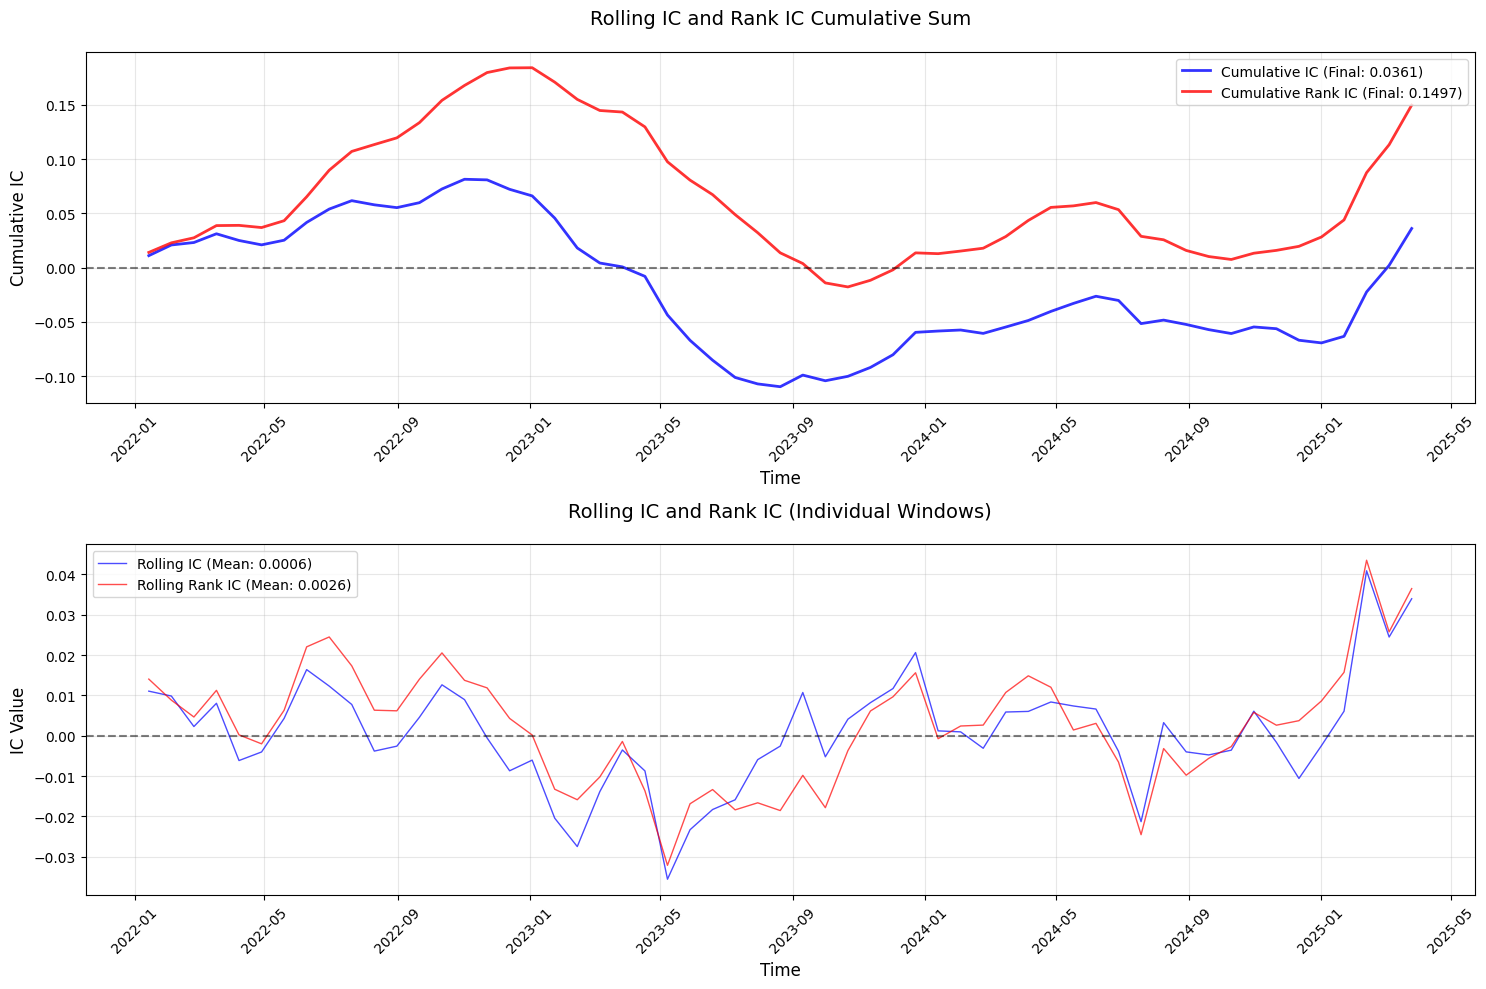

✅ 已显示 4 个图片
----------------------------------------


In [6]:
evaluator.set_factor(
    factor_func=calculate_peak_count,
    factor_name='volume_peak_count'
)
result1 = evaluator.run_full_evaluation(run_stationarity_test=False)

# 因子2: 量岭分钟数因子

In [7]:
def calculate_ridge_count(df):
    """
    量岭分钟数因子：滚动窗口内量岭出现的次数
    """
    volume_state = calculate_volume_state(df)
    # 过去1天窗口(96根K线)的量岭计数
    return volume_state.eq(2).rolling(96).sum()

因子测试框架 - 量岭分钟数因子


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.022733
   Rank_IC (Spearman): 0.018256
📊 信息比率:
   IR: 0.321873
   有效分组数: 8
📊 因子分布:
📋 数据概况:
   数据长度: 132016
   因子列: volume_ridge_count
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


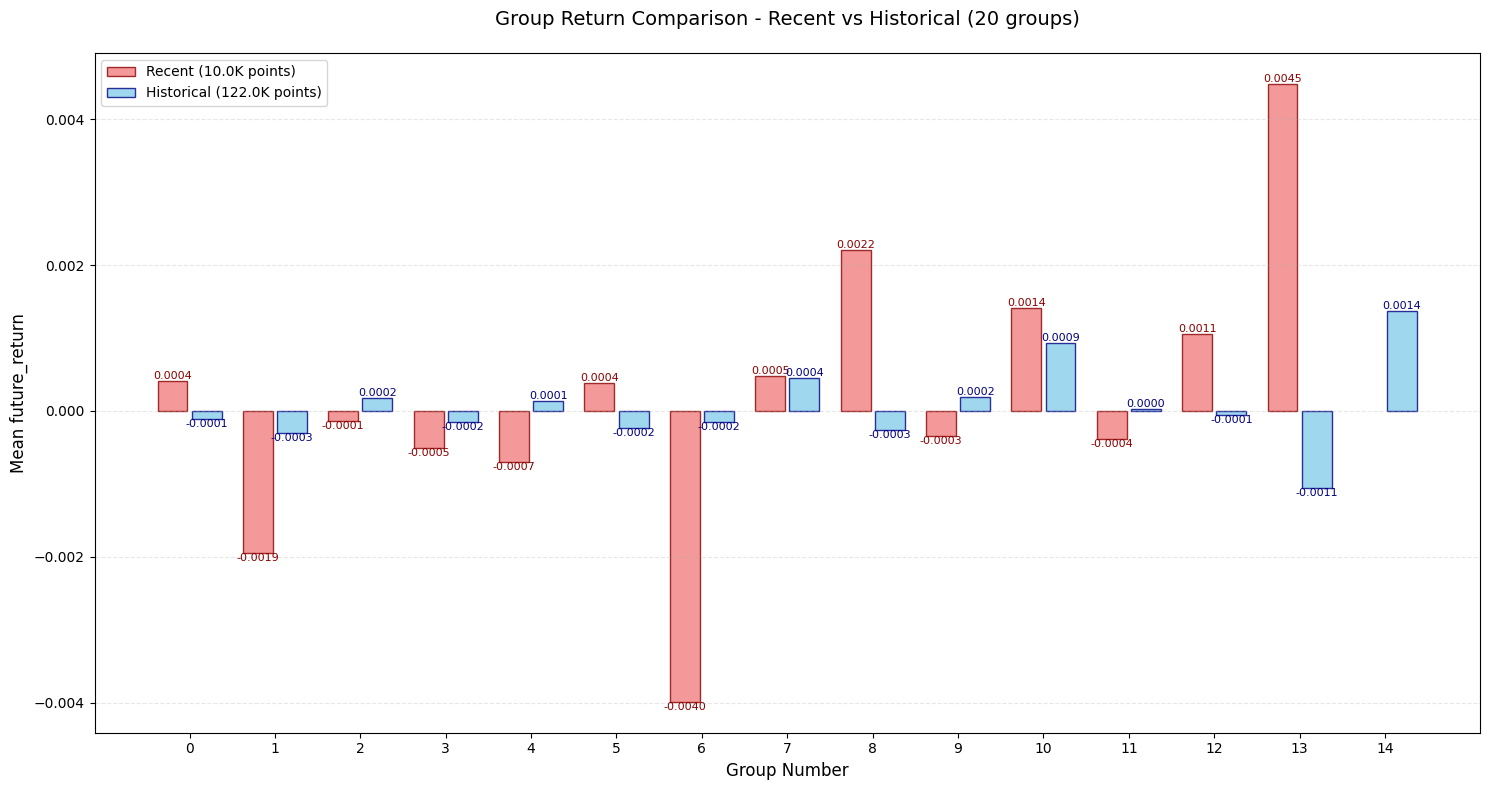

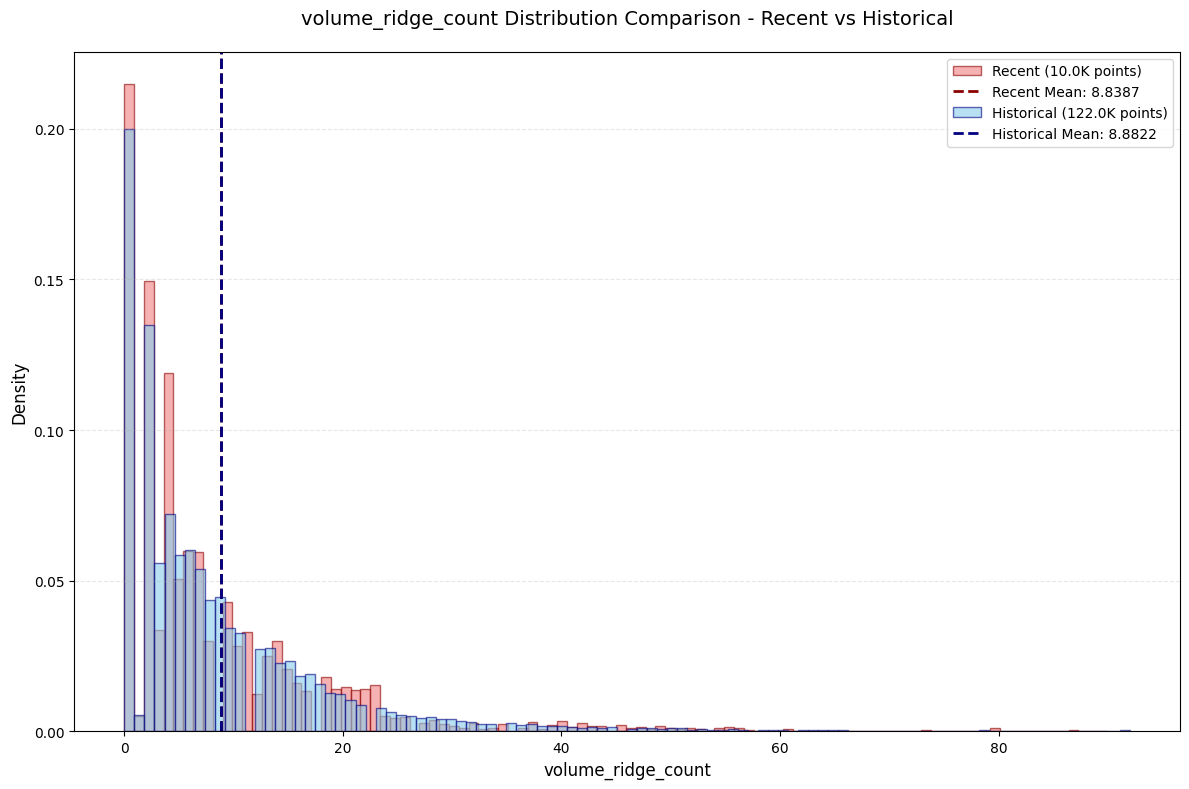

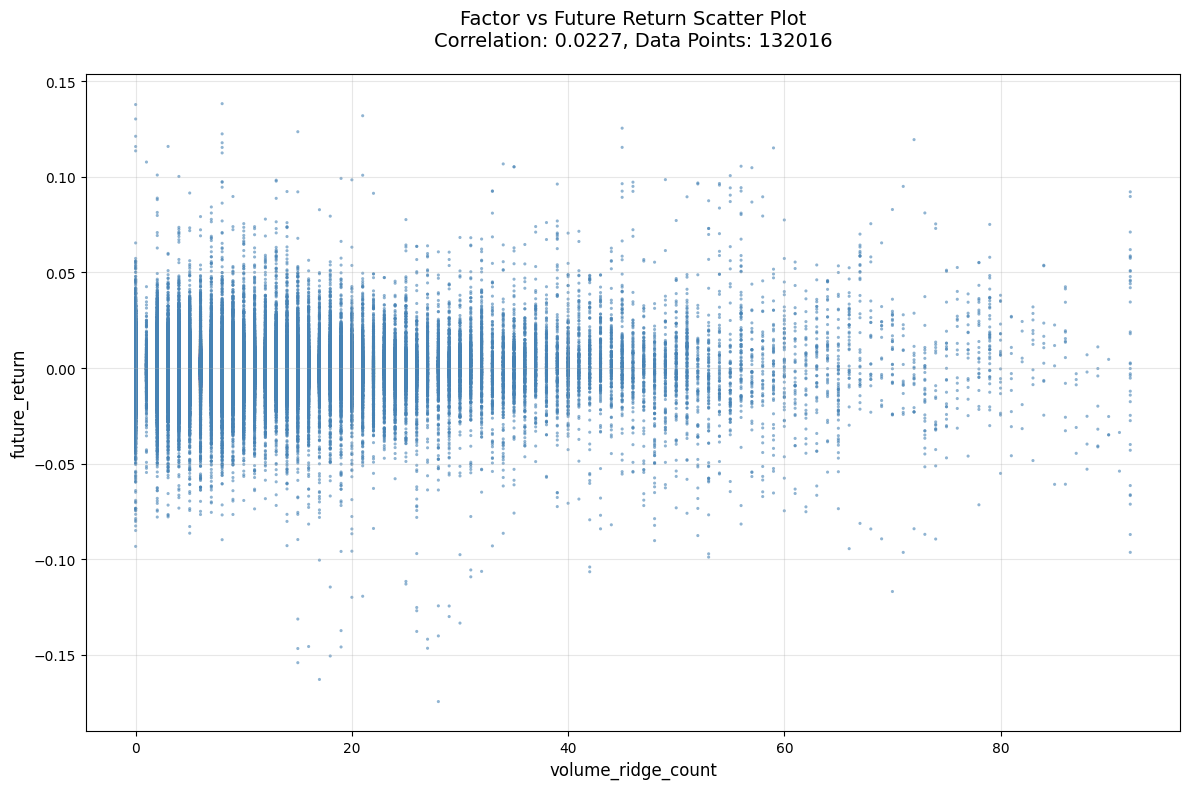

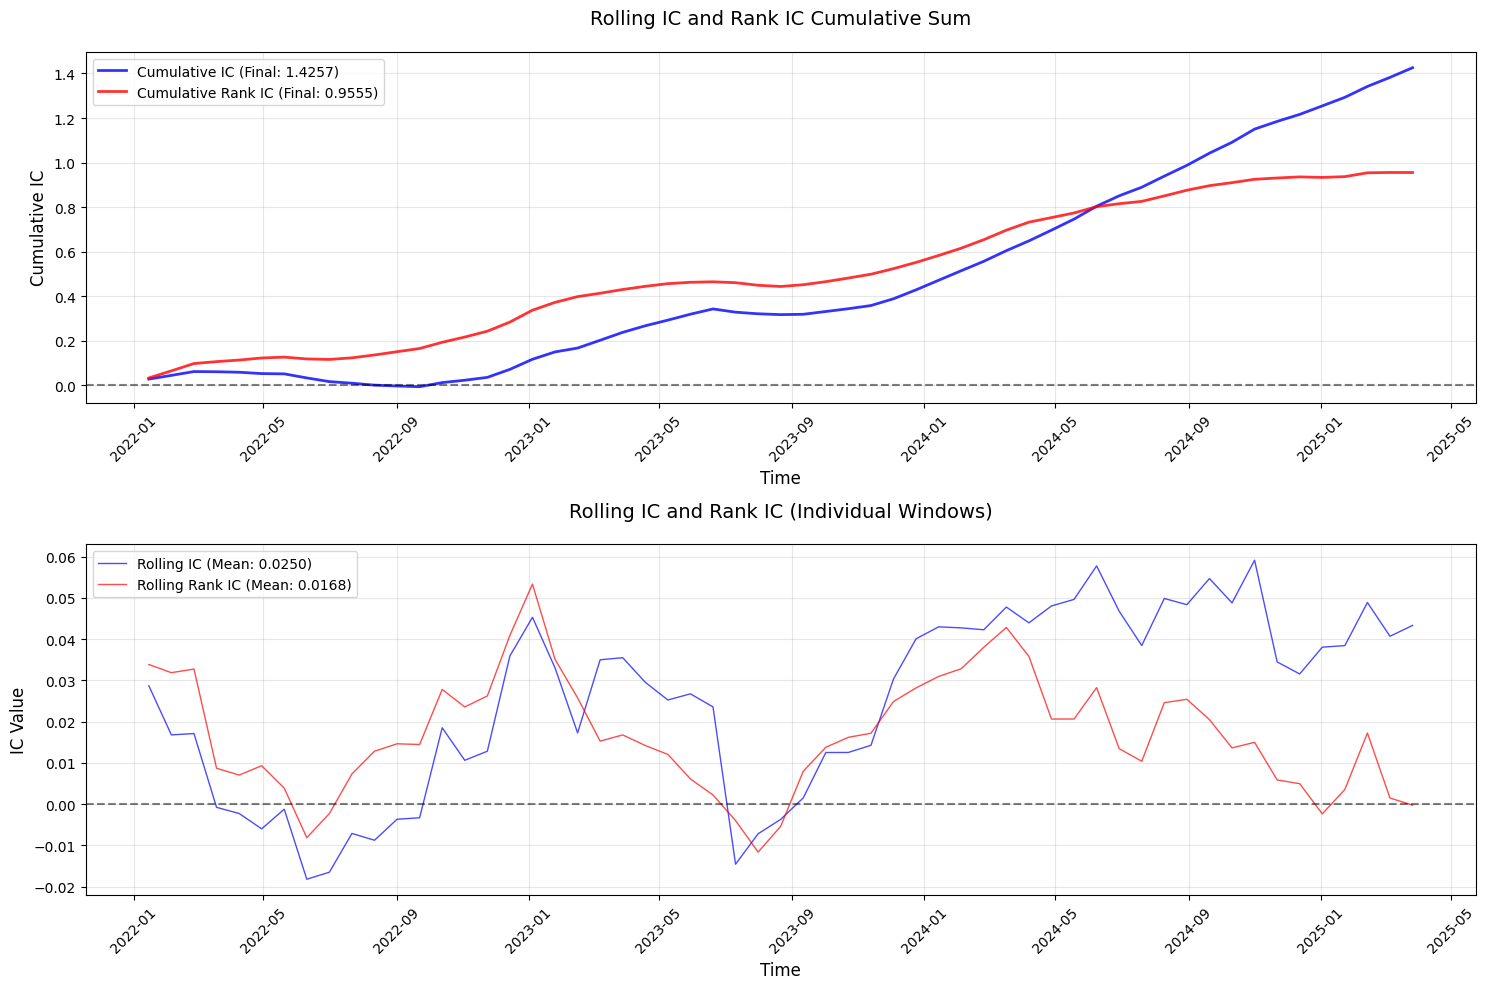

✅ 已显示 4 个图片
----------------------------------------


In [8]:
evaluator.set_factor(
    factor_func=calculate_ridge_count,
    factor_name='volume_ridge_count'
)
result2 = evaluator.run_full_evaluation(run_stationarity_test=False)

# 因子3: 量岭分钟收益因子

In [9]:
def calculate_ridge_return(df):
    """
    量岭分钟收益因子：量岭发生时K线的收益率
    """
    volume_state = calculate_volume_state(df)
    returns = df['close'] / df['open'] - 1  # 本K线收益率
    
    # 仅保留量岭时的收益，其他时间设为0
    ridge_returns = returns.where(volume_state == 2, 0)
    
    # 过去6小时(24根K线)的平均量岭收益
    return ridge_returns.rolling(24).mean()

因子测试框架 - 量岭分钟收益因子


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): -0.002937
   Rank_IC (Spearman): -0.002498
📊 信息比率:
   IR: -0.231943
   有效分组数: 6
📊 因子分布:
📋 数据概况:
   数据长度: 131993
   因子列: ridge_minute_return
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


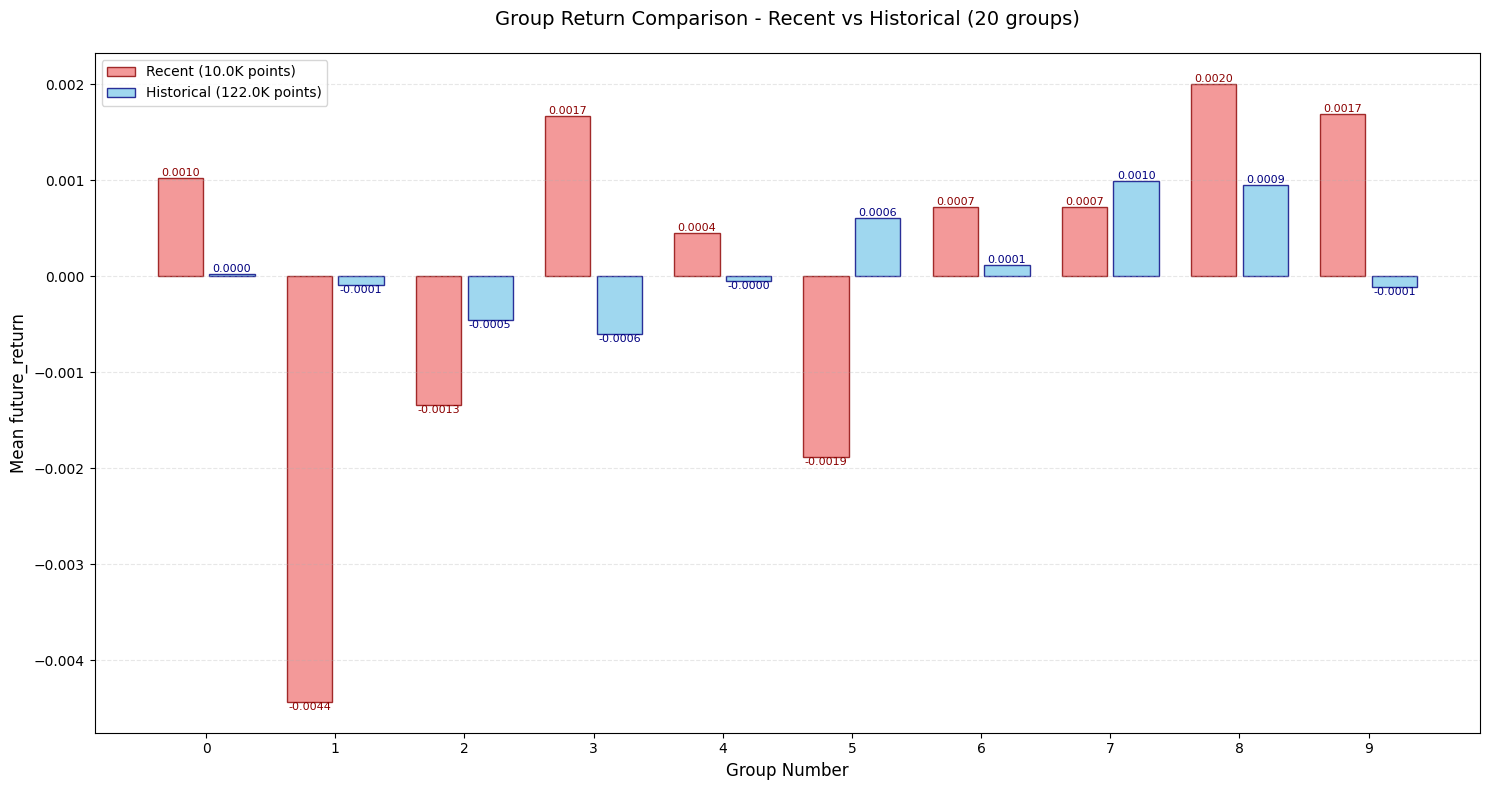

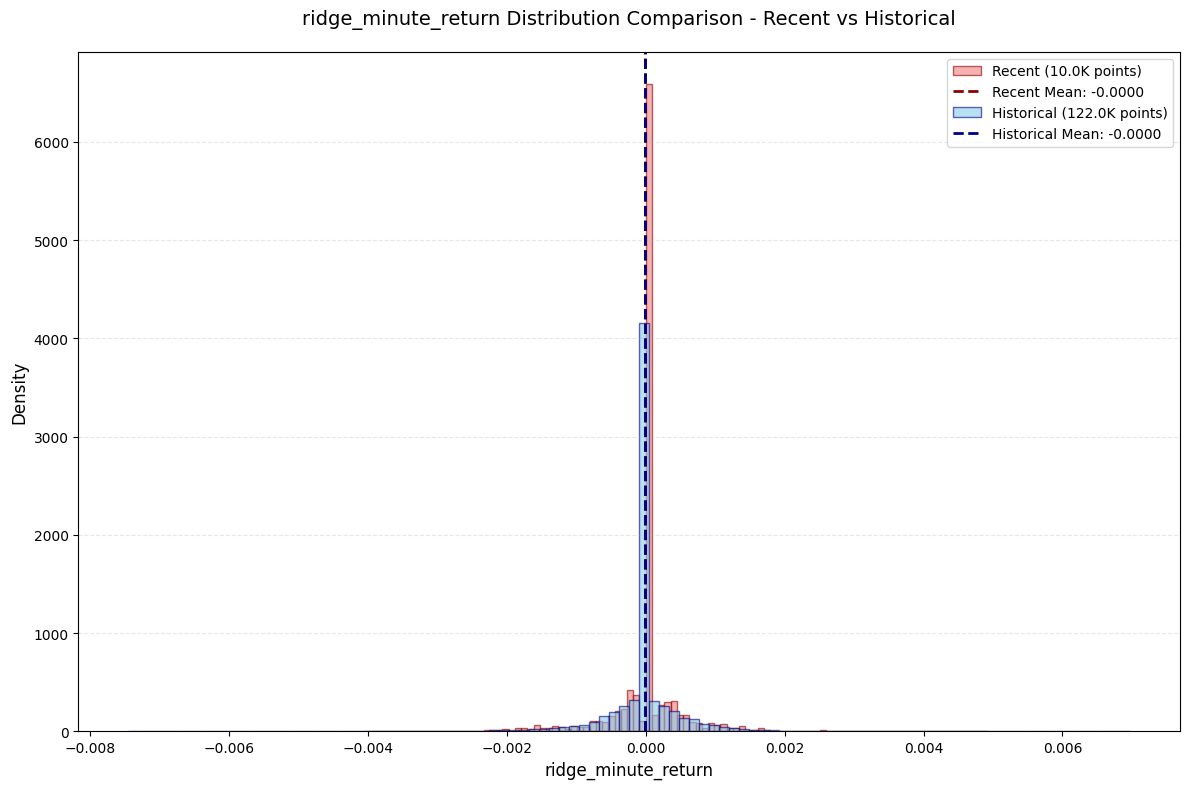

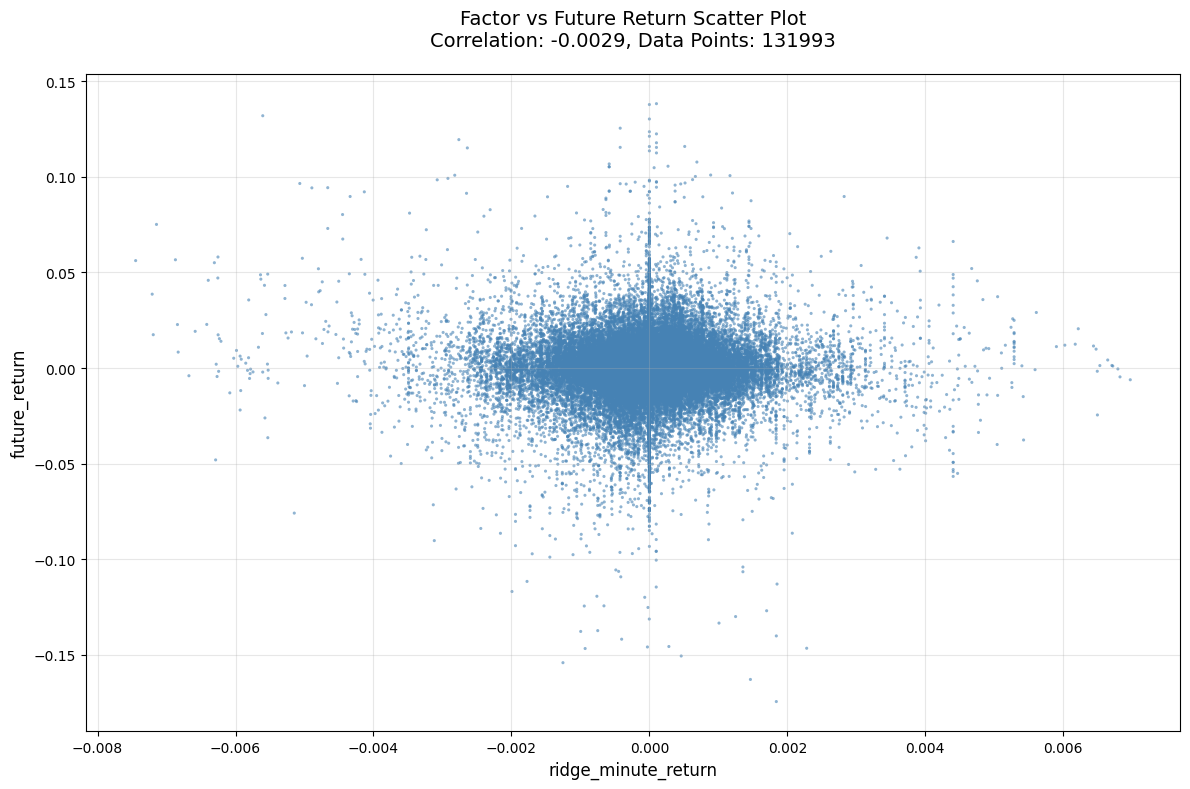

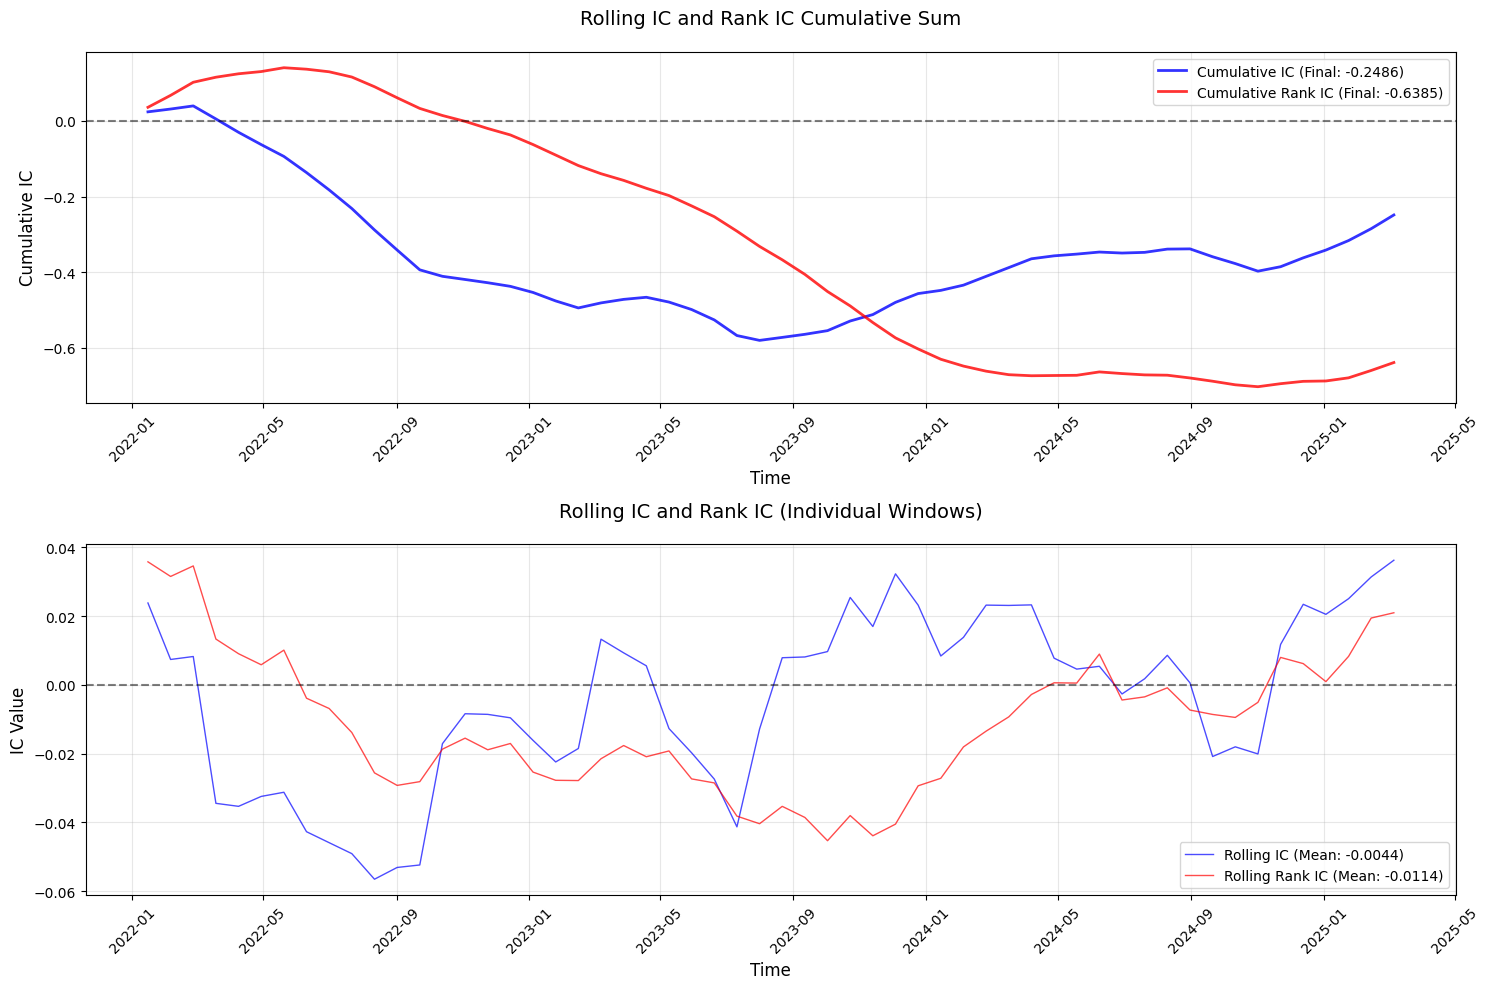

✅ 已显示 4 个图片
----------------------------------------


In [10]:
evaluator.set_factor(
    factor_func=calculate_ridge_return,
    factor_name='ridge_minute_return'
)
result3 = evaluator.run_full_evaluation(run_stationarity_test=False)

# 因子4: 量谷相对VWAP因子

In [11]:
def calculate_valley_vwap_ratio(df):
    """
    量谷相对VWAP因子：量谷时收盘价与当日VWAP的比值
    """
    volume_state = calculate_volume_state(df)
    
    # 计算每日VWAP (成交量加权平均价)
    daily_vwap = (df['turnover'] / df['volume']).resample('D').last().reindex(df.index, method='ffill')
    
    # 计算相对VWAP比率
    vwap_ratio = df['close'] / daily_vwap - 1
    
    # 仅保留量谷时的比率，其他时间设为0
    valley_ratio = vwap_ratio.where(volume_state == 0, 0)
    
    # 过去12小时(48根K线)的平均比率
    return valley_ratio.rolling(48).mean()

因子测试框架 - 量谷相对VWAP因子


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): -0.373128
   Rank_IC (Spearman): -0.300235
📊 信息比率:
   IR: -0.773462
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 131946
   因子列: valley_vwap_ratio
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


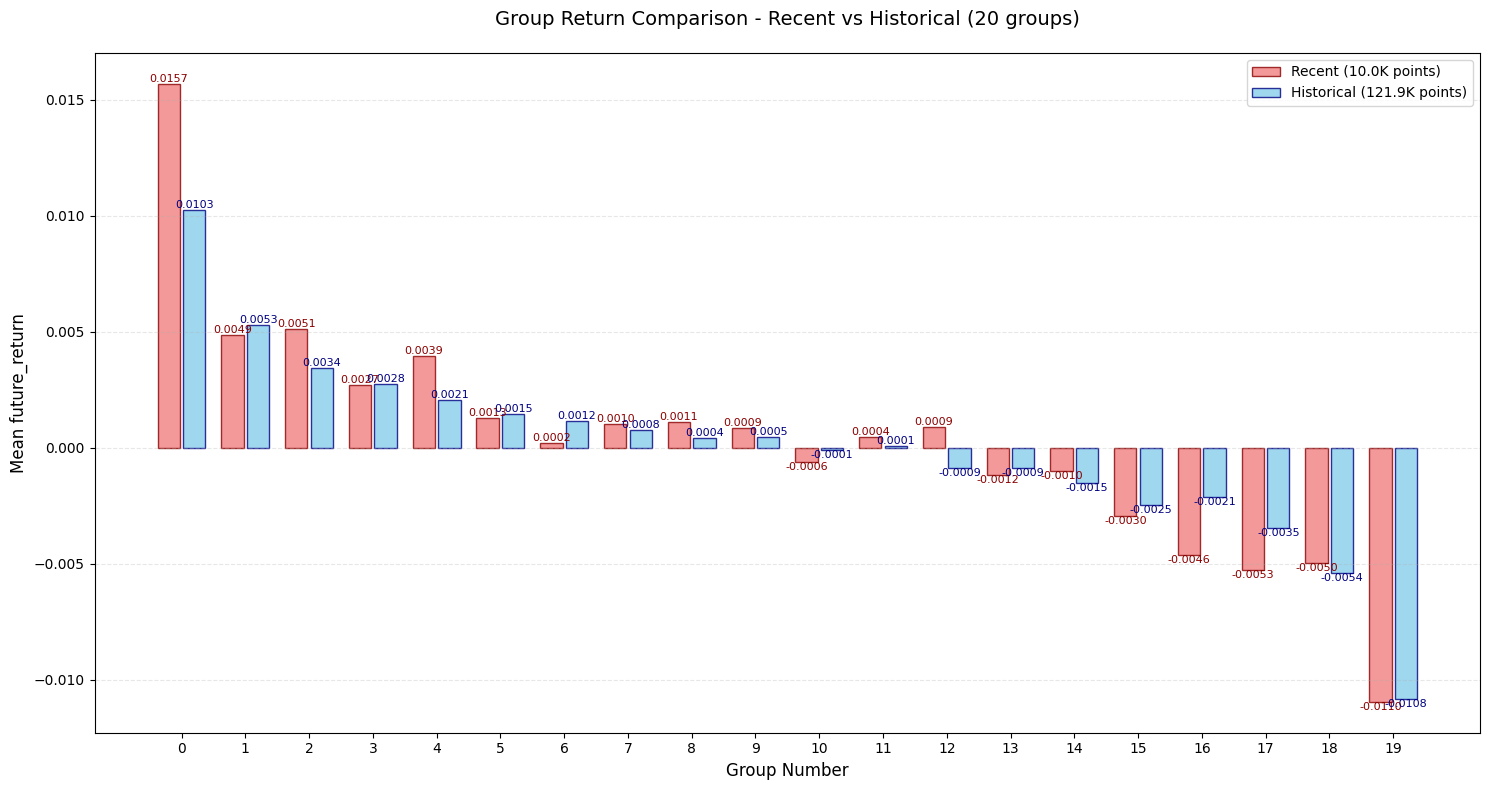

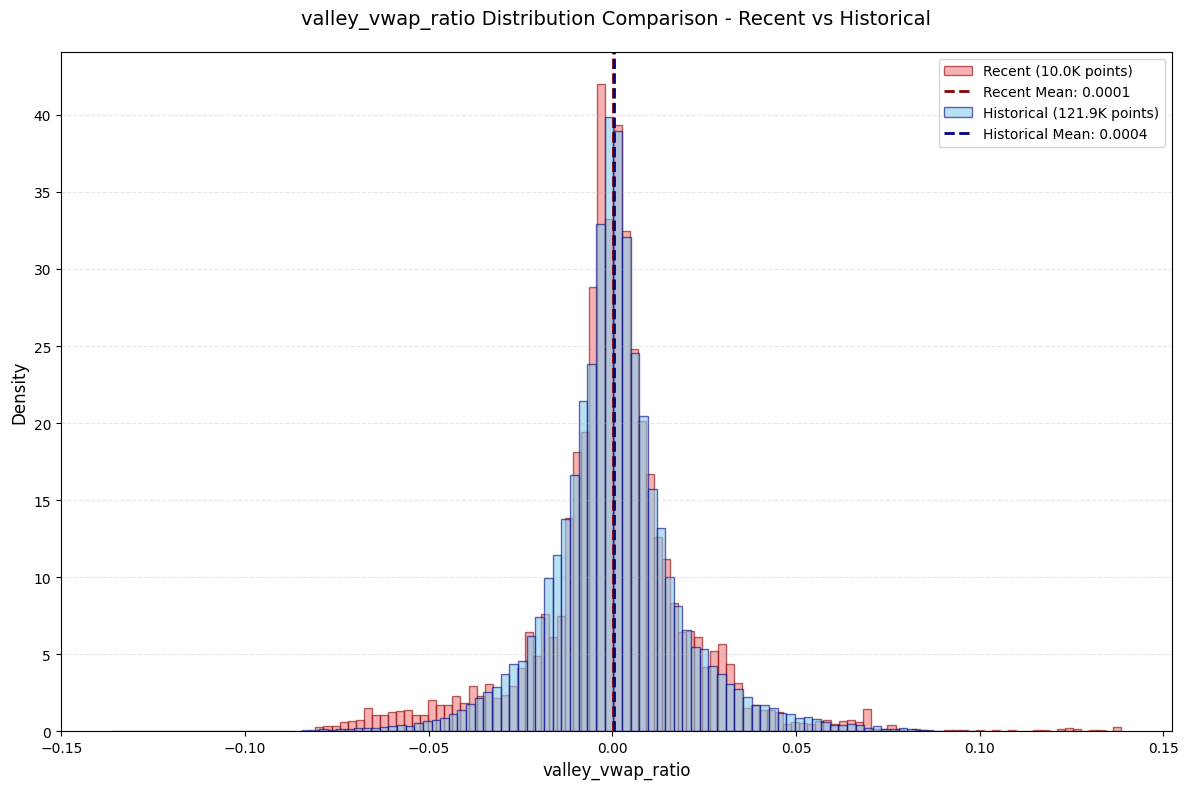

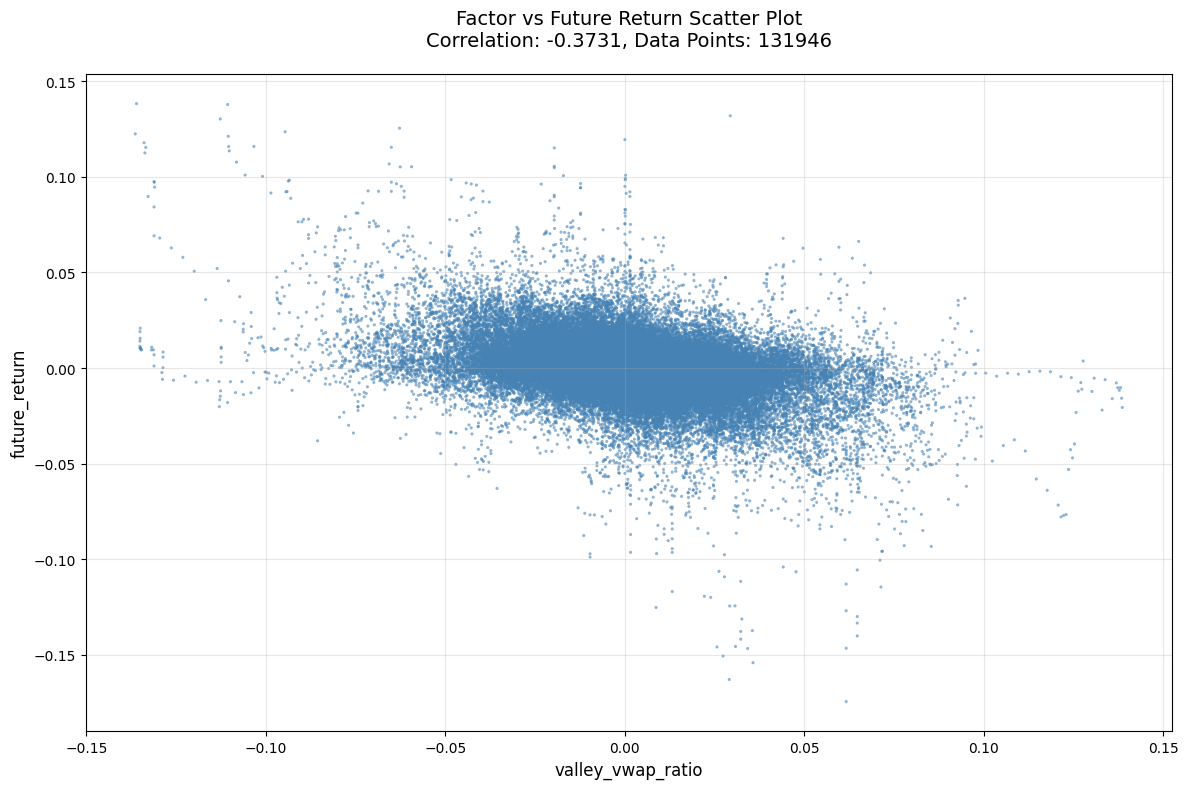

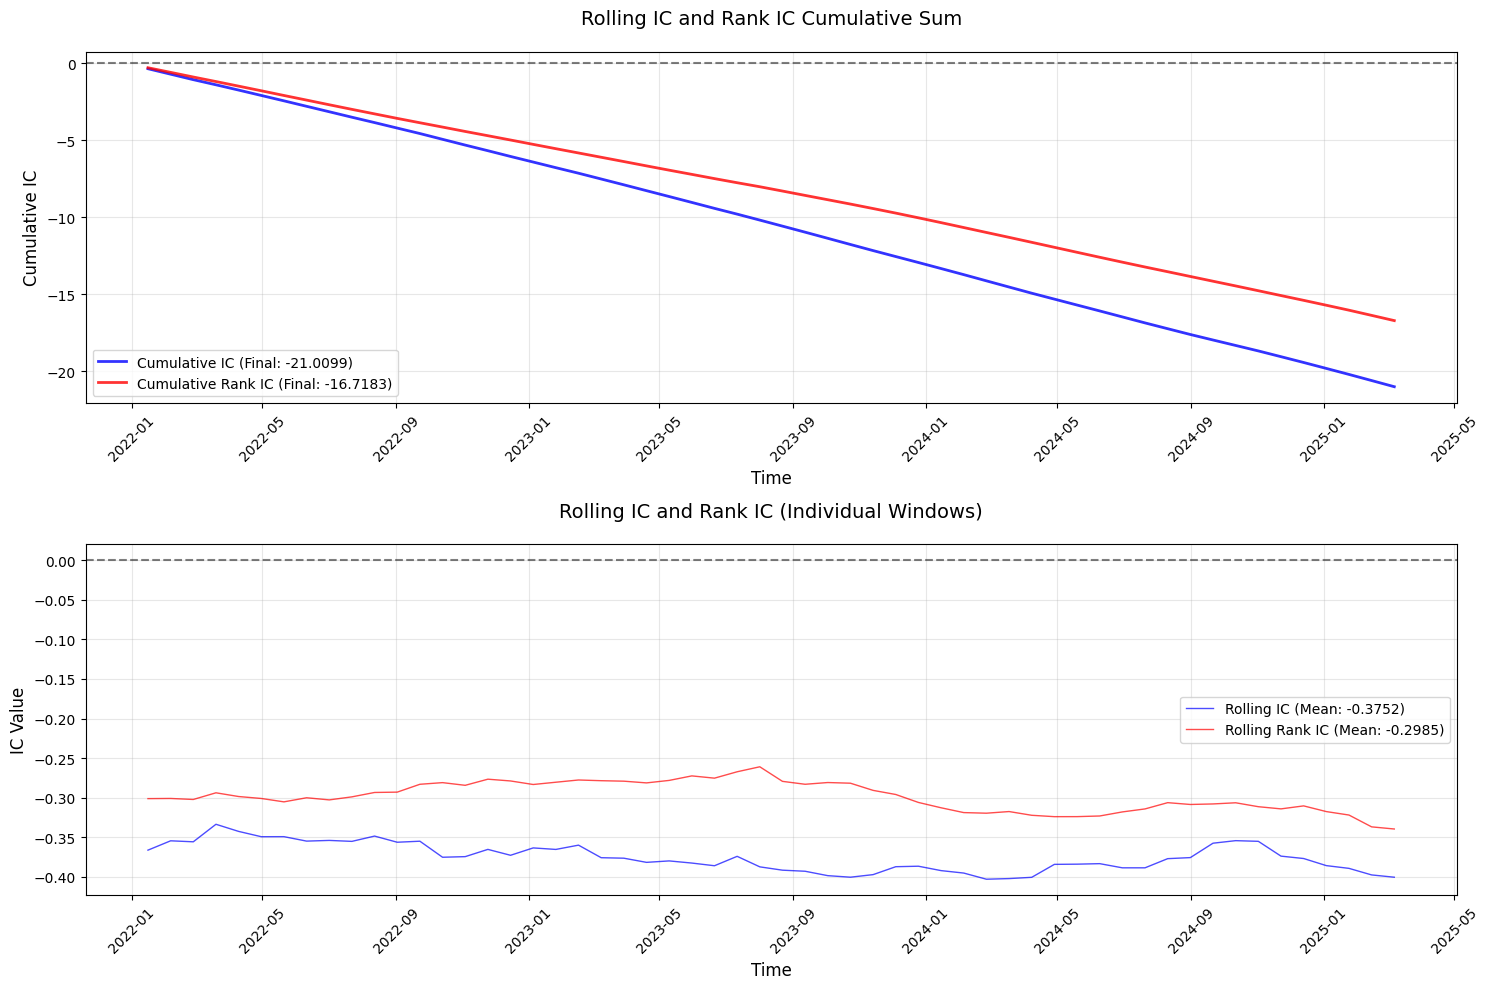

✅ 已显示 4 个图片
----------------------------------------


In [12]:
evaluator.set_factor(
    factor_func=calculate_valley_vwap_ratio,
    factor_name='valley_vwap_ratio'
)
result4 = evaluator.run_full_evaluation(run_stationarity_test=False)

# 因子5: 量峰价格分位因子

In [13]:
def calculate_peak_price_quantile(df):
    """
    量峰价格分位因子：量峰时价格在K线范围内的位置
    """
    volume_state = calculate_volume_state(df)
    
    # 计算价格分位：(收盘价-最低价)/(最高价-最低价)
    price_quantile = (df['close'] - df['low']) / (df['high'] - df['low'] + 1e-8)
    
    # 仅保留量峰时的分位值，其他时间设为0
    peak_quantile = price_quantile.where(volume_state == 1, 0)
    
    # 过去8小时(32根K线)的平均分位值
    return peak_quantile.rolling(32).mean()

因子测试框架 - 量峰价格分位因子


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): -0.007010
   Rank_IC (Spearman): -0.008212
📊 信息比率:
   IR: 0.291910
   有效分组数: 7
📊 因子分布:
📋 数据概况:
   数据长度: 131915
   因子列: peak_price_quantile
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


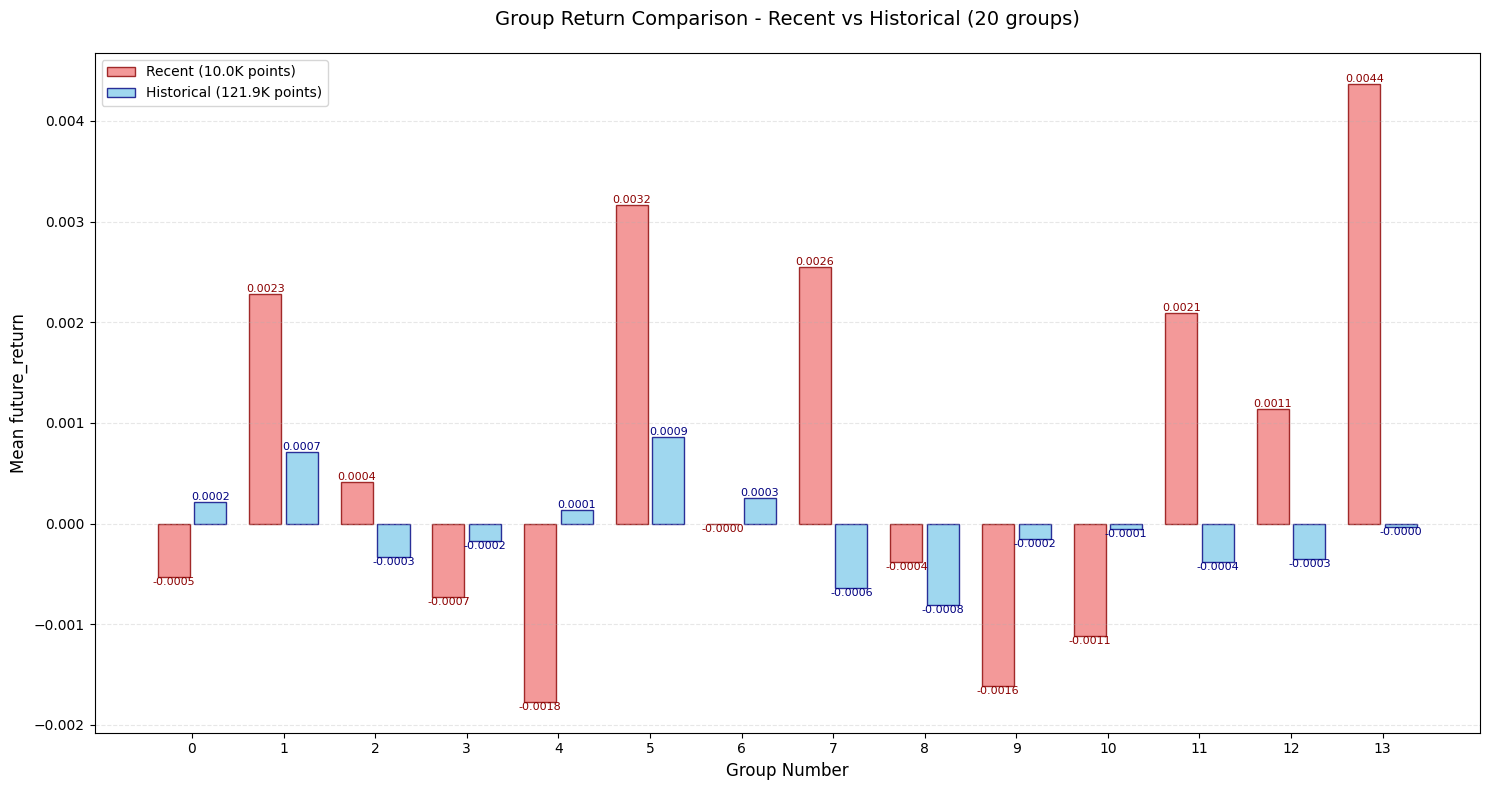

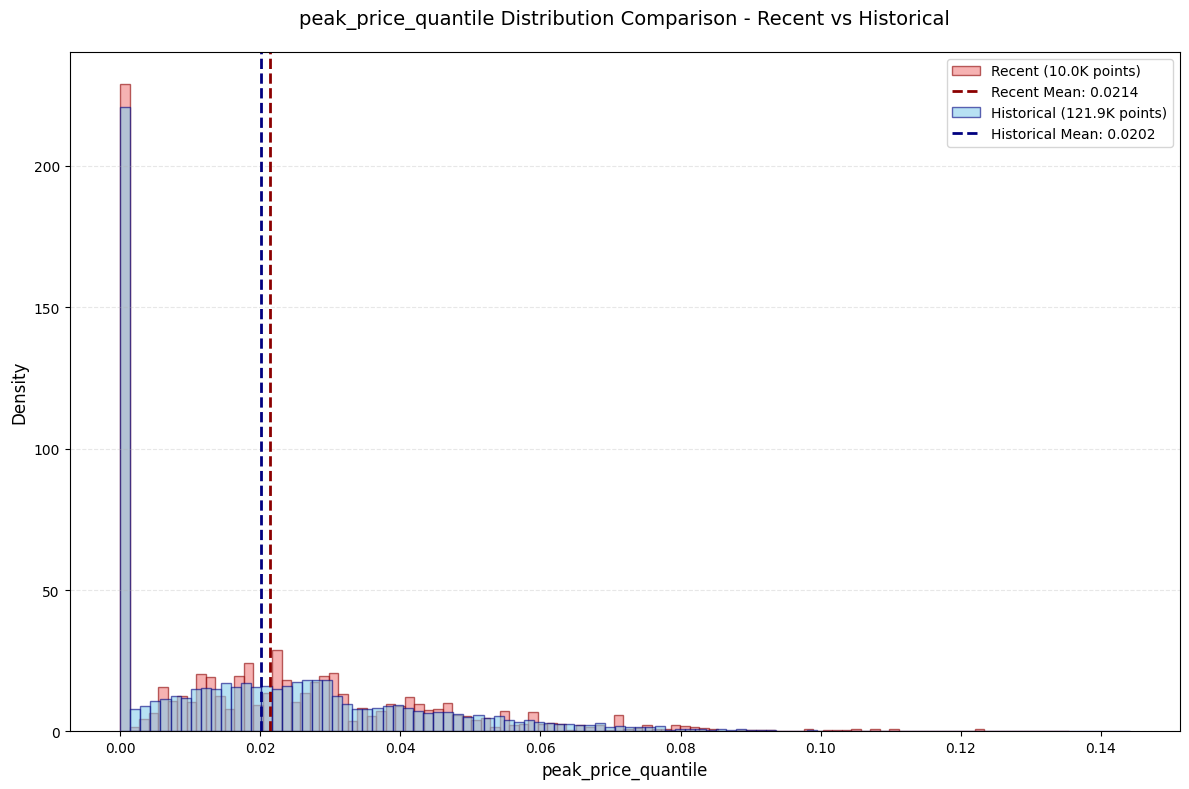

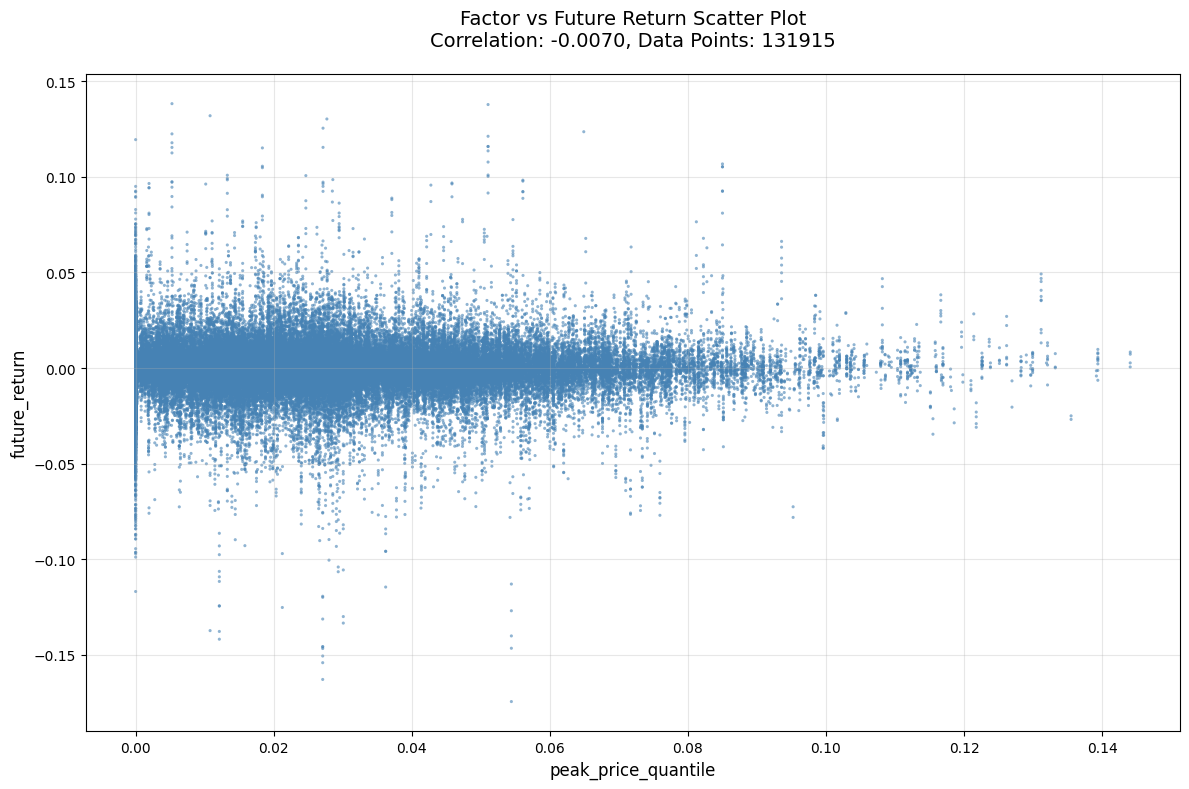

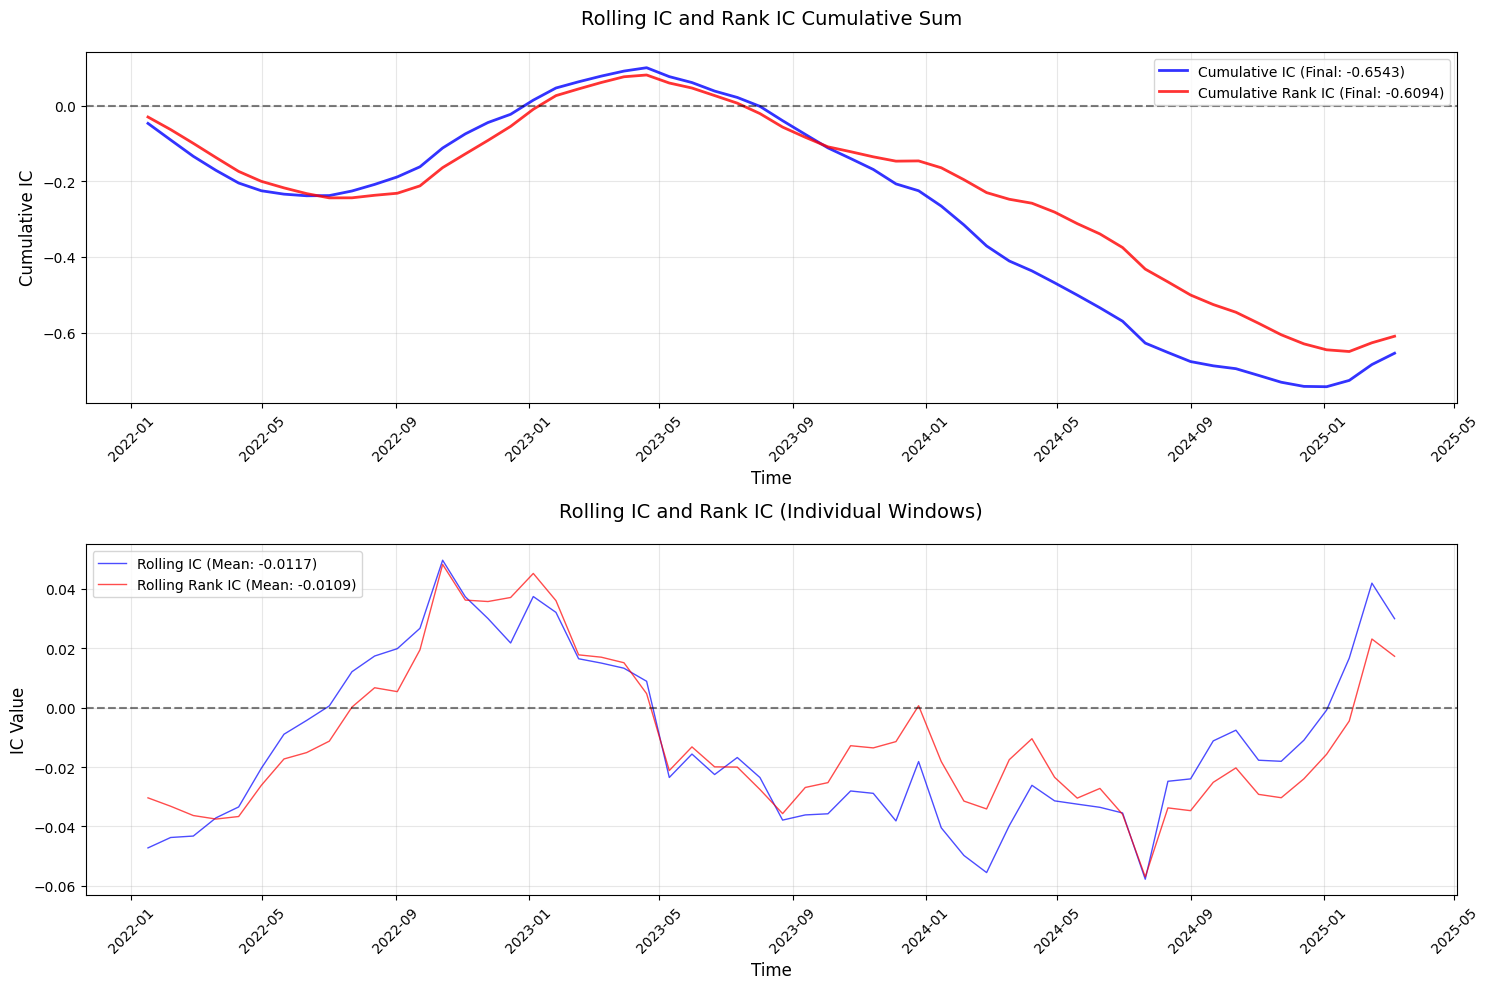

✅ 已显示 4 个图片
----------------------------------------


In [14]:
evaluator.set_factor(
    factor_func=calculate_peak_price_quantile,
    factor_name='peak_price_quantile'
)
result5 = evaluator.run_full_evaluation(run_stationarity_test=False)